# <center> We are the DaDTeam! </center>
<center> Balazs Fodor, Hodvogner Szilvia, Gergely Dobreff </center>

## Goal
We choose topic NLP2 (ChatBot based on deep learning) for the Deep Learning Course's homework. Our goal is to build a Neural Network for the [SMCalFlow challenge](https://microsoft.github.io/task_oriented_dialogue_as_dataflow_synthesis/). This competition was announced by Microsoft Semantic Machine, the motivation for this competition is that one of the central challenges in conversational AI is the design of a dialogue state representation that agents can use to reason about the information and actions available to them. They have developed a new representational framework for dialogue that enables efficient machine learning of complex conversations.

## Dataset
SMCalFlow is a large English-language dialogue dataset, featuring natural conversations about tasks involving calendars, weather, places, and people. It has 41,517 conversations annotated with dataflow programs. In contrast to existing dialogue datasets, this dialogue collection was not based on pre-specified scripts, and participants were not restricted in terms of what they could ask for and how they should accomplish their tasks. As a result, SMCalFlow is qualitatively different from existing dialogue datasets, featuring explicit discussion about agent capabilities, multi-turn error recovery, and complex goals.

## Reference
The original scientific paper about the framework, the dataset and their baseline solution can be found [here](https://www.mitpressjournals.org/doi/10.1162/tacl_a_00333), a shorter summary in the form of a blog post can be found [at this link](https://www.microsoft.com/en-us/research/blog/dialogue-as-dataflow-a-new-approach-to-conversational-ai/). 

Microsoft also opensourced a [github repository](https://github.com/microsoft/task_oriented_dialogue_as_dataflow_synthesis) containing codes to reproduce their results in the article. The library can be installed with pip using the following command:
```sh
pip install git+https://github.com/microsoft/task_oriented_dialogue_as_dataflow_synthesis.git
```

---

In the following, we present this dataset and our preliminary solution proposals.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import json
import pprint

In [2]:
# import or install and import the github library related to the original article
try:
    from dataflow.core import lispress
except ImportError as error:
    !pip install git+https://github.com/microsoft/task_oriented_dialogue_as_dataflow_synthesis.git
    print(error)
    from dataflow.core import lispress

  Cloning https://github.com/microsoft/task_oriented_dialogue_as_dataflow_synthesis.git to /tmp/pip-req-build-12gkyzwm
  Running command git clone -q https://github.com/microsoft/task_oriented_dialogue_as_dataflow_synthesis.git /tmp/pip-req-build-12gkyzwm
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 7.5MB 4.9MB/s 
     |████████████████████████████████| 51kB 9.6MB/s 
     |████████████████████████████████| 10.1MB 28.0MB/s 
     |████████████████████████████████| 10.2MB 25.4MB/s 
     |████████████████████████████████| 8.7MB 57.6MB/s 
     |████████████████████████████████| 2.1MB 46.2MB/s 
  Created wheel for sm-dataflow: filename=sm_dataflow-0.1-cp36-none-any.whl size=74037 sha256=1d575886923bf3b5243cf91b761019b7e59e6ded28e18bf4345a7d550d9b3e00
  Stored in directory: /tmp/pip-ephem-wheel-cache-cy5_rgv7/wheels/29/56/7d/e4f971aa5ccc90cf2913a8e38b90001ff65429eb0e0697804f
  Created wheel for sexpdata: filename=sexpdata-0.0.3-cp36-none-any.wh

No module named 'dataflow'


Download dataset and extract it

In [3]:
!mkdir data
!wget -c https://smresearchstorage.blob.core.windows.net/smcalflow-public/smcalflow.full.data.tgz -O - | tar -xz -C data

--2020-11-18 10:44:02--  https://smresearchstorage.blob.core.windows.net/smcalflow-public/smcalflow.full.data.tgz
Resolving smresearchstorage.blob.core.windows.net (smresearchstorage.blob.core.windows.net)... 52.191.176.36
Connecting to smresearchstorage.blob.core.windows.net (smresearchstorage.blob.core.windows.net)|52.191.176.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13703288 (13M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>]  13.07M  17.1MB/s    in 0.8s    

2020-11-18 10:44:03 (17.1 MB/s) - written to stdout [13703288/13703288]



## Dataset analysis and preparation

In [4]:
# wrapper class for displaying the conversations in the dataset
class ConvWrapper:
    def __init__(self,data):
        self.data = data

    def show_conv(self,showProgram=False):
        for turn in self.data['turns']:
            print('User> ',turn['user_utterance']['original_text'])
            if(showProgram):
                LisPress = lispress.parse_lispress(turn['lispress'])
                print('PROGRAM: ')
                print(lispress.render_pretty(LisPress))
            print('Agent> ',turn['agent_utterance']['original_text'])
    def print(self):
        pprint.pprint(self.data)
    

In [5]:
# load train dataset
train = []
with open("data/train.dataflow_dialogues.jsonl") as trainfile:
    content = trainfile.read()
    train = [json.loads(line) for line in content.splitlines()]

In [6]:
# display the first training conversation
example = ConvWrapper(train[0])
example.show_conv()

User>  what date is tomorrow?
Agent>  Tomorrow's date is February 5, 2019.
User>  What day of the week is tomorrow?
Agent>  Tomorrow is Wednesday.
User>  please help me
Agent>  I can help you create, update, and delete events on your calendar. You can also ask me about your schedule.


In [7]:
# display the first two training conversations with the corresponding lispress programs (the inner representation of the dialogue state) at each turn
example = ConvWrapper(train[0])
example.show_conv(True)
print('\n-----------------------------------------------------------------------------------\n')
example = ConvWrapper(train[1])
example.show_conv(True)

User>  what date is tomorrow?
PROGRAM: 
(Yield :output (Tomorrow))
Agent>  Tomorrow's date is February 5, 2019.
User>  What day of the week is tomorrow?
PROGRAM: 
(Yield :output (:dayOfWeek (Tomorrow)))
Agent>  Tomorrow is Wednesday.
User>  please help me
PROGRAM: 
(PleasantryCalendar)
Agent>  I can help you create, update, and delete events on your calendar. You can also ask me about your schedule.

-----------------------------------------------------------------------------------

User>  What time is my appointment with Jerri Skinner on Friday?
PROGRAM: 
(Yield
  :output (:start
    (singleton
      (:results
        (FindEventWrapperWithDefaults
          :constraint (EventOnDate
            :date (NextDOW :dow #(DayOfWeek "FRIDAY"))
            :event (Constraint[Event]
              :attendees (AttendeeListHasRecipientConstraint
                :recipientConstraint (RecipientWithNameLike
                  :constraint (Constraint[Recipient])
                  :name #(PersonName "J

In [8]:
# display one training data with all fields:
example = ConvWrapper(train[0])
example.print()

{'dialogue_id': '8c112de4-0c61-43b1-b437-8e176fed39b6',
 'turns': [{'agent_utterance': {'described_entities': [],
                                'original_text': "Tomorrow's date is February "
                                                 '5, 2019.',
                                'tokens': ['Tomorrow',
                                           "'s",
                                           'date',
                                           'is',
                                           'February',
                                           '5',
                                           ',',
                                           '2019',
                                           '.']},
            'lispress': '(Yield :output (Tomorrow))',
            'program_execution_oracle': {'has_exception': False,
                                         'refer_are_correct': True},
            'skip': True,
            'turn_index': 0,
            'user_utterance': {'original_text'

The training data contains an id and the turns of the dialogue, each turn consists the user message, and the agent response, with the following important meta information:


*   tokens and original text for both the user message and the agent response
*   turn_index: the sequence number of that turn
*   lispress
    * the program that stores the inner state of the conversation
    * the agent should generate a response based on this

---



In [9]:
# load validation data
valid = []
with open("data/valid.dataflow_dialogues.jsonl") as validfile:
    content = validfile.read()
    valid = [json.loads(line) for line in content.splitlines()]

In [10]:
# print an example
valid_example = ConvWrapper(valid[0])
valid_example.print()

{'dialogue_id': 'f40ad346-9cb4-46a2-8d6d-13926371cffd',
 'turns': [{'agent_utterance': {'described_entities': ['entity@1135690515'],
                                'original_text': 'Is this good?',
                                'tokens': ['Is', 'this', 'good', '?']},
            'lispress': '(Yield :output (CreateCommitEventWrapper :event '
                        '(CreatePreflightEventWrapper :constraint '
                        '(Constraint[Event] :attendees (andConstraint '
                        '(AttendeeListHasRecipient :recipient (Execute '
                        ':intension (refer (extensionConstraint '
                        '(RecipientWithNameLike :constraint '
                        '(Constraint[Recipient]) :name #(PersonName '
                        '"Jeff")))))) (AttendeeListHasRecipient :recipient '
                        '(Execute :intension (refer (extensionConstraint '
                        '(RecipientWithNameLike :constraint '
                        '(Con

The validation data consists the same structure of dialogues

### Start and end tags for decoder input

In [11]:
for dialog in train:
    for turn in dialog["turns"]:
        turn.update({"lispress_cleaned":"<begin> "+turn["lispress"]+" <eos>"})

for dialog in valid:
    for turn in dialog["turns"]:
        turn.update({"lispress_cleaned":"<begin> "+turn["lispress"]+" <eos>"})

In [12]:
valid[0]["turns"][0]["lispress_cleaned"]

'<begin> (Yield :output (CreateCommitEventWrapper :event (CreatePreflightEventWrapper :constraint (Constraint[Event] :attendees (andConstraint (AttendeeListHasRecipient :recipient (Execute :intension (refer (extensionConstraint (RecipientWithNameLike :constraint (Constraint[Recipient]) :name #(PersonName "Jeff")))))) (AttendeeListHasRecipient :recipient (Execute :intension (refer (extensionConstraint (RecipientWithNameLike :constraint (Constraint[Recipient]) :name #(PersonName "John"))))))) :duration (?= (toHours #(Number 1))) :location (?= #(LocationKeyphrase "Conference Room B")) :start (?= (DateAtTimeWithDefaults :date (NextDOW :dow #(DayOfWeek "THURSDAY")) :time (NumberPM :number #(Number 4)))) :subject (?= #(String "discuss analytics")))))) <eos>'

### Tokenize texts
Although the train and validation data are tokenized (contain a field with the tokens), but the tokens are not converted to lowercase and special characters are also included, so further data cleaning is necessary

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
# create a tokenizer and fit on the sentences of the train data dialogues
tokenizer_user = Tokenizer()
dialogue_sent = [turn['user_utterance']['original_text'] for dialog in train for turn in dialog['turns'] ]
tokenizer_user.fit_on_texts(dialogue_sent)
# index of "the"
tokenizer_user.word_index["the"]

1

In [15]:
# create a tokenizer and fit on the sentences of the train data dialogues
lispress_tokenizer = Tokenizer()
dialogue_sent_lispress = [turn['lispress_cleaned'] for dialog in train for turn in dialog['turns'] ]
lispress_tokenizer.fit_on_texts(dialogue_sent_lispress)


In [16]:
lispress_tokenizer.word_index["begin"]

3

In [17]:
# example: tokens of the first two sentences
[[tokenizer_user.index_word[code] for code in seq] for seq in tokenizer_user.texts_to_sequences(dialogue_sent[:2]) ]

[['what', 'date', 'is', 'tomorrow'],
 ['what', 'day', 'of', 'the', 'week', 'is', 'tomorrow']]

In [18]:
def tokenizeDialogues(dataset,tokenizer):
    """
    Add a tokens2 attribute to the user_utterance in each turn with the token indexes
    Add a tokens2_readable attribute to the user_utterance with the readable tokens
    """
    for dialog in dataset:
        for turn in dialog['turns']:
            seq = tokenizer.texts_to_sequences([turn["user_utterance"]["original_text"]])[0]
            turn["user_utterance"].update({"tokens2":seq,"tokens2_readable":[tokenizer.index_word[index] for index in seq]})
    tokenizedSet = [[ turn['user_utterance']['tokens2'] for turn in dialog['turns'] ]for dialog in dataset]
    return tokenizedSet,dataset

def tokenizeLispress(dataset,tokenizer):
    """
    Add a tokens2 attribute to the user_utterance in each turn with the token indexes
    Add a tokens2_readable attribute to the user_utterance with the readable tokens
    """
    for dialog in dataset:
        for turn in dialog['turns']:
            seq = tokenizer.texts_to_sequences([turn["lispress_cleaned"]])[0]
            turn.update({"lispress_tokens":seq,"lispress_tokens_readable":[tokenizer.index_word[index] for index in seq]})
    tokenizedSet = [[ turn['lispress_tokens'] for turn in dialog['turns'] ]for dialog in dataset]
    return tokenizedSet,dataset

In [19]:
train_tokenized,train = tokenizeDialogues(train,tokenizer=tokenizer_user)
valid_tokenized,valid = tokenizeDialogues(valid,tokenizer=tokenizer_user)

In [20]:
train_tokenized_lispress,train_lispress = tokenizeLispress(train,tokenizer=lispress_tokenizer)
valid_tokenized_lispress,valid_lispress = tokenizeLispress(valid,tokenizer=lispress_tokenizer)

In [21]:
# example: tokens generated from a message
print("message:",train[0]["turns"][0]["user_utterance"]["original_text"])
print("tokens:",train[0]["turns"][0]["user_utterance"]["tokens2"])
print("readable tokens:",train[0]["turns"][0]["user_utterance"]["tokens2_readable"])
print("lispress tokens:",train[0]["turns"][0]["lispress_tokens"])
print("lispress tokens:",train[0]["turns"][0]["lispress_tokens_readable"])

message: what date is tomorrow?
tokens: [18, 101, 12, 22]
readable tokens: ['what', 'date', 'is', 'tomorrow']
lispress tokens: [3, 6, 5, 52, 4]
lispress tokens: ['begin', 'yield', 'output', 'tomorrow', 'eos']


In [22]:
def flatten_nested_list(list0):
    """
    Flatten the nested list's elements
    Example:
    [[1,2],[3]] => [1,2,3]
    """
    return [element for nested in list0 for element in nested ]

In [23]:
# part of the train data converted to fix sized vectors
example_train_data = tokenizer_user.sequences_to_matrix(flatten_nested_list(train_tokenized)[:10])
# vectors with 16297 elements
example_train_data.shape

(10, 16297)

In [24]:
# size of the dictiorary:
print("size of the dictionary:",len(tokenizer_user.index_word))

size of the dictionary: 16296


## Data analysis

In [ ]:
def calculate_freq_list(item_list):
    """
    Calculate item frequencies in the given list
    """
    freq_list = {}
    for item in item_list:
        if item in freq_list:
            freq_list[item] += 1
        else:
            freq_list[item] = 1

    sorted_freq_list = {k: v for k, v in sorted(freq_list.items(), key=lambda item: item[1], reverse=True)}
    return sorted_freq_list

In [ ]:
def calculate_ngrams_and_freq(tokenized_dataset, ngram_size):
    """
    Create the list of all ngrams, n is given as parameter called ngram_size
    Calculate the frequencies of the ngrams
    """
    token_sequences_ngrams = flatten_nested_list([tf.strings.ngrams(seq, ngram_size).numpy() for seq in tokenized_dataset])
    token_sequences_ngrams = [x.decode('utf-8') for x in token_sequences_ngrams]    
    sorted_ngram_freq = calculate_freq_list(token_sequences_ngrams)
    return token_sequences_ngrams, sorted_ngram_freq

### User utterances

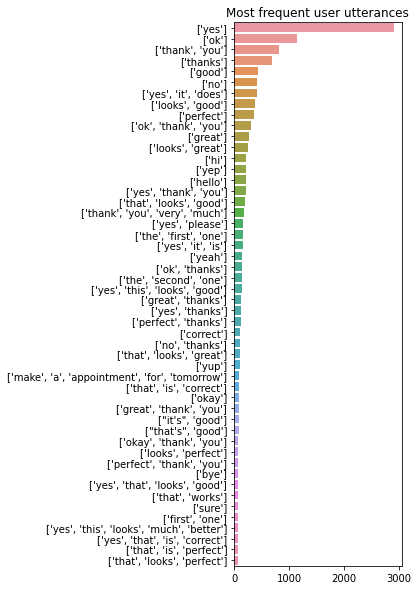

In [ ]:
user_utteraces = [str(turn['user_utterance']['tokens2_readable']) for dialog in train for turn in dialog['turns']]
user_utt_freq = calculate_freq_list(user_utteraces)

plt.figure(figsize=(3,10))
plt.title("Most frequent user utterances")
sns.barplot(x=list(user_utt_freq.values())[:50], y=list(user_utt_freq.keys())[:50], orient="h")

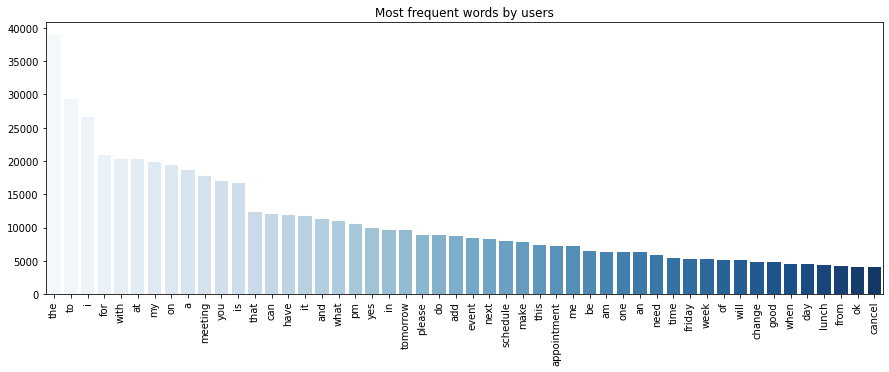

In [ ]:
x = [key for key in list(tokenizer_user.index_word.values())[:50]]
y = [tokenizer_user.word_counts[key] for key in x]

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.title("Most frequent words by users")
sns.barplot(x=x, y=y, palette="Blues")

In [ ]:
token_sequences = [turn['user_utterance']['tokens2_readable'] for dialog in train for turn in dialog['turns']]
token_sequences_ngrams, sorted_ngram_freq = calculate_ngrams_and_freq(token_sequences, 2)
print("Number of unique bigrams:", len(sorted_ngram_freq))

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.title("Most frequent bigrams by users")
sns.barplot(x=list(sorted_ngram_freq.keys())[:50], y = list(sorted_ngram_freq.values())[:50], palette="Blues")

In [ ]:
token_sequences_ngrams, sorted_ngram_freq = calculate_ngrams_and_freq(token_sequences, 3)
print("Number of unique 3grams:", len(sorted_ngram_freq))

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.title("Most frequent 3grams by users")
sns.barplot(x=list(sorted_ngram_freq.keys())[:50], y = list(sorted_ngram_freq.values())[:50], palette="flare")

### Agent utterances

In [ ]:
dialogue_agent = [turn['agent_utterance']['original_text'] for dialog in train for turn in dialog['turns']]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dialogue_agent)

In [ ]:
x = [key for key in list(tokenizer.index_word.values())[:50]]
y = [tokenizer.word_counts[key] for key in x]

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.title("Most frequent words by the agent")
sns.barplot(x=x, y=y, palette="flare")

In [ ]:
sorted_ans_freq = calculate_freq_list(dialogue_agent)

plt.figure(figsize=(3,10))
plt.title("Most frequent agent utterances")
sns.barplot(x=list(sorted_ans_freq.values())[:30], y=list(sorted_ans_freq.keys())[:30], orient="h")

### Code

In [ ]:
codes = [turn['lispress'] for dialog in train for turn in dialog['turns']]
sorted_code_freq = calculate_freq_list(codes)
code_lengths = [len(code) for code in sorted_code_freq.keys()]
print("Avarage code length (chars):", np.mean(code_lengths))

In [ ]:
key_list = list(sorted_code_freq.keys())
value_list = list(sorted_code_freq.values())
for i in range(20):
    print("Frequency:", value_list[i])
    print("Code:")
    print(key_list[i])
    print()

In [ ]:
lispress_tokens = [str(turn['lispress_tokens_readable']) for dialog in train for turn in dialog['turns']]
lispress_tokens_freq = calculate_freq_list(lispress_tokens)

plt.figure(figsize=(3,10))
plt.title("Most frequent lispress commands")
sns.barplot(x=list(lispress_tokens_freq.values())[:50], y=list(lispress_tokens_freq.keys())[:50], orient="h")

In [ ]:
x = [key for key in list(lispress_tokenizer.index_word.values())[:50]]
y = [lispress_tokenizer.word_counts[key] for key in x]

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.title("Most frequent words by the agent")
sns.barplot(x=x, y=y, palette="Blues")

## Examples


In [25]:
from dataflow.analysis import compute_data_statistics

### Basic statistics

In [ ]:
compute_data_statistics.main("data", ['train', 'valid'], "output")

In [ ]:
# print basic statistics about the full dataset
with open('output/train-valid.basic_stats.json') as json_file:
    data = json.load(json_file)
    pprint.pprint(data)

## Target of the challenge
The main target of the challenge is to create algorithms that are able to maintain and update conversation states stored as a program (or as a graph). The output for each user message should be a so called lispress string which is a representation of the stored agent program (see examples above).

The predictions can be evaluated in [codalab](https://codalab.org/), using Microsoft's predefined scripts. Predictions need to be made for all the validation data, and submitted to the codalab platform, and the scripts will evaluate the accuracy. 


## Roadmap
Since the original article contains a baseline solution for this challenge, our first step will be to understand and reproduce the baseline solution to better understand the problem the article addresses.

After that, with the deep analysis of the state of the art solutions, we will extend, or replace the baseline solution with our custom algorithm.

Our final goal is to create a model whose prediction outperforms the baseline solution


# Work

In [26]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding,Dense,Activation
from tensorflow.keras.layers import Input, LSTM, Dense

## Create train and test data

In [27]:
MAX_TRAIN_DATA=-1
MAX_VALID_DATA=-100
MAX_TEST_DATA=99

In [28]:
from copy import deepcopy
def create_decoder_input(data):
  """
  from each dealogue -> remove the last element, and add a 0 to the beginning
  """
  data_tmp = deepcopy(data)
  for seqs in data_tmp:
    del seqs[-1]
    seqs.insert(0,[0])
  return data_tmp

In [29]:
demo = train_tokenized[:4]

demo2 = create_decoder_input(demo)

In [30]:
print(demo)
print(demo2)

[[[18, 101, 12, 22], [18, 46, 41, 1, 40, 12, 22], [23, 163, 32]], [[18, 38, 12, 7, 31, 5, 488, 526, 8, 39], [14, 11, 25, 36, 31, 5, 488, 526, 6, 112, 34], [3, 37, 16, 2, 71, 54, 95], [44, 51]], [[14, 11, 1075, 47, 5, 374, 17, 204, 178], [949, 1, 496, 160, 33, 1284, 47, 17, 174, 374], [25, 544, 110, 5103, 3813, 2477, 640, 289, 470, 417], [39, 128, 1653, 2078, 43, 1, 38, 2, 121, 4356, 126, 5104, 23], [113, 18, 3, 37, 51, 17, 267, 863, 4, 1, 47]], [[25, 455, 8, 64, 2000, 86, 62, 34, 2, 65, 62, 19], [11, 167, 18, 1556, 1654, 939, 342, 239, 130, 16, 6, 86, 61], [43, 1, 245, 2, 455, 46], [153, 105], [153, 44]]]
[[[0], [18, 101, 12, 22], [18, 46, 41, 1, 40, 12, 22]], [[0], [18, 38, 12, 7, 31, 5, 488, 526, 8, 39], [14, 11, 25, 36, 31, 5, 488, 526, 6, 112, 34], [3, 37, 16, 2, 71, 54, 95]], [[0], [14, 11, 1075, 47, 5, 374, 17, 204, 178], [949, 1, 496, 160, 33, 1284, 47, 17, 174, 374], [25, 544, 110, 5103, 3813, 2477, 640, 289, 470, 417], [39, 128, 1653, 2078, 43, 1, 38, 2, 121, 4356, 126, 5104, 

In [31]:
len(flatten_nested_list(train_tokenized))

133821

In [32]:
train_data = flatten_nested_list(train_tokenized)[:MAX_TRAIN_DATA]
valid_data = flatten_nested_list(valid_tokenized)[:MAX_VALID_DATA]
test_data = flatten_nested_list(valid_tokenized)[MAX_VALID_DATA:MAX_VALID_DATA+MAX_TEST_DATA]

train_data_di = flatten_nested_list(create_decoder_input(train_tokenized_lispress))[:MAX_TRAIN_DATA]
valid_data_di = flatten_nested_list(create_decoder_input(valid_tokenized_lispress))[:MAX_VALID_DATA]
test_data_di = flatten_nested_list(create_decoder_input(valid_tokenized_lispress))[MAX_VALID_DATA:MAX_VALID_DATA+MAX_TEST_DATA]

train_data_y = flatten_nested_list(train_tokenized_lispress)[:MAX_TRAIN_DATA]
valid_data_y = flatten_nested_list(valid_tokenized_lispress)[:MAX_VALID_DATA]
test_data_y = flatten_nested_list(valid_tokenized_lispress)[MAX_VALID_DATA:MAX_VALID_DATA+MAX_TEST_DATA]


## Padding encoder and decoder input

[Towardsdatascience - seq2seq +preprocess ](https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639)

In [33]:
from keras.preprocessing.sequence import pad_sequences

In [34]:
MAX_LEN=50

encoder_train = pad_sequences(train_data,maxlen=MAX_LEN,dtype="int32",padding='post', truncating='post')
decoder_train = pad_sequences(train_data_y,maxlen=MAX_LEN,dtype="int32",padding='post', truncating='post')
decoder_train_input = pad_sequences(train_data_di,maxlen=MAX_LEN,dtype="int32",padding='post', truncating='post')

encoder_valid = pad_sequences(valid_data,maxlen=MAX_LEN,dtype="int32",padding='post', truncating='post')
decoder_valid = pad_sequences(valid_data_y,maxlen=MAX_LEN,dtype="int32",padding='post', truncating='post')
decoder_valid_input = pad_sequences(valid_data_di,maxlen=MAX_LEN,dtype="int32",padding='post', truncating='post')

encoder_test = pad_sequences(test_data,maxlen=MAX_LEN,dtype="int32",padding='post', truncating='post')
decoder_test = pad_sequences(test_data_y,maxlen=MAX_LEN,dtype="int32",padding='post', truncating='post')
decoder_test_input = pad_sequences(test_data_di,maxlen=MAX_LEN,dtype="int32",padding='post', truncating='post')

In [35]:
decoder_train_input[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

## Word Embedding with Glove

In [36]:
import os

In [ ]:

# !wget "http://nlp.stanford.edu/data/glove.6B.zip" -O temp.zip
# !unzip temp.zip -d glove
# !rm temp.zip

--2020-11-17 21:42:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-17 21:42:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-17 21:42:38--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘temp.zip’

temp.zip   

In [38]:
from google.colab import drive
drive.mount('/content/drive/')
root_path = 'drive/My Drive/msc/dl_hf/'  #change dir to your project folder

Mounted at /content/drive/


In [39]:
GLOVE_DIR="glove"
embeddings_index = {}
with open(os.path.join(root_path,GLOVE_DIR,"glove.6B.100d.txt"),'rb') as f:
    for line in f.readlines():
        values = line.split()
        word = str(values[0],encoding="utf8")
        coefs = np.asanyarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs


In [40]:
# create embedding matrix for the encoder
embedding_dimension = 100
DECODING_DEPTH = len(lispress_tokenizer.word_index)+1
embedding_matrix_encoder = np.zeros((len(tokenizer_user.word_index)+1,embedding_dimension))
for word, i in tokenizer_user.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_encoder[i] = embedding_vector

# create embedding matrix for the decoder
embedding_matrix_decoder = np.zeros((DECODING_DEPTH,embedding_dimension))
for word, i in lispress_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i < DECODING_DEPTH:
        embedding_matrix_decoder[i] = embedding_vector

In [41]:
embedding_matrix_encoder[1]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

In [42]:
def decoder_output_creater(decoder_input_data, num_samples, MAX_LEN, VOCAB_SIZE):  
    decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="float32")

    for i, seqs in enumerate(decoder_input_data):
        for j, seq in enumerate(seqs):
            if j > 0 and seq < VOCAB_SIZE:
                decoder_output_data[i][j][seq] = 1.
    #print(decoder_output_data.shape)

    return decoder_output_data

In [43]:
from sklearn.preprocessing import OneHotEncoder

def decoder_output_creator(decoder_input_data, num_samples, MAX_LEN, VOCAB_SIZE):
  enc = OneHotEncoder(categories=list(range(VOCAB_SIZE)))
  print(enc.categories_)
  return enc.fit_transform(decoder_input_data)

## Simple Embedding

[keras lstm seq2seq](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

In [44]:
from keras.layers import Bidirectional, Concatenate

## Model -> Both bidirectional  -> more layers


In [59]:
num_encoder_tokens = len(tokenizer_user.word_index)+1
num_decoder_tokens = len(lispress_tokenizer.word_index)+1
HIDDEN_DIM = 128

print("encoder tokens",num_encoder_tokens)

# Define an input sequence and process it.
embedding_dimension=100
encoder_inputs = Input(shape=(MAX_LEN, ),dtype="int32")
encoder_embedding = Embedding(input_dim = num_encoder_tokens,
                            output_dim = embedding_dimension,
                            input_length = MAX_LEN,
                            weights = [embedding_matrix_encoder],
                           trainable = False)(encoder_inputs)

encoder_LSTM = Bidirectional(LSTM(HIDDEN_DIM, return_state=True), merge_mode="concat")
encoder_outputs, forward_h, forward_c, backward_c, backward_h = encoder_LSTM(encoder_embedding)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [forward_h, forward_c, backward_h, backward_c]


# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(MAX_LEN, ),dtype="int32")
decoder_embedding = Embedding(input_dim = DECODING_DEPTH,
                            output_dim = embedding_dimension,
                            input_length = MAX_LEN,
                            weights = [embedding_matrix_decoder],
                           trainable = False)(decoder_inputs)
decoder_LSTM_1 = Bidirectional(LSTM(HIDDEN_DIM, return_state=False, return_sequences=True), merge_mode="concat")(decoder_embedding, initial_state=encoder_states)
decoder_LSTM_2 = Bidirectional(LSTM(HIDDEN_DIM, return_state=False, return_sequences=True), merge_mode="concat")

decoder_outputs = decoder_LSTM_2(decoder_LSTM_1)

outputs = Dense(DECODING_DEPTH, activation='softmax')(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], outputs)

encoder tokens 16297


## Model -> Both the encoder and the decoder are bidirectional

In [45]:
# num_encoder_tokens = len(tokenizer_user.word_index)+1
# num_decoder_tokens = len(lispress_tokenizer.word_index)+1
# HIDDEN_DIM = 128

# print("encoder tokens",num_encoder_tokens)

# # Define an input sequence and process it.
# embedding_dimension=100
# encoder_inputs = Input(shape=(MAX_LEN, ),dtype="int32")
# encoder_embedding = Embedding(input_dim = num_encoder_tokens,
#                             output_dim = embedding_dimension,
#                             input_length = MAX_LEN,
#                             weights = [embedding_matrix_encoder],
#                            trainable = False)(encoder_inputs)

# encoder_LSTM = Bidirectional(LSTM(HIDDEN_DIM, return_state=True), merge_mode="concat")
# encoder_outputs, forward_h, forward_c, backward_c, backward_h = encoder_LSTM(encoder_embedding)
# state_h = Concatenate()([forward_h, backward_h])
# state_c = Concatenate()([forward_c, backward_c])
# encoder_states = [forward_h, forward_c, backward_h, backward_c]


# # Set up the decoder, using `encoder_states` as initial state.
# decoder_inputs = Input(shape=(MAX_LEN, ),dtype="int32")
# decoder_embedding = Embedding(input_dim = DECODING_DEPTH,
#                             output_dim = embedding_dimension,
#                             input_length = MAX_LEN,
#                             weights = [embedding_matrix_decoder],
#                            trainable = False)(decoder_inputs)
# decoder_LSTM = Bidirectional(LSTM(HIDDEN_DIM, return_state=False, return_sequences=True), merge_mode="concat")


# decoder_outputs = decoder_LSTM(decoder_embedding, initial_state=encoder_states)

# outputs = Dense(DECODING_DEPTH, activation='softmax')(decoder_outputs)
# model = Model([encoder_inputs, decoder_inputs], outputs)

encoder tokens 16297


## Model -> Only Encoder is bidirectional, decoder is not

In [ ]:
# num_encoder_tokens = len(tokenizer_user.word_index)+1
# num_decoder_tokens = len(lispress_tokenizer.word_index)+1
# HIDDEN_DIM = 128

# print("encoder tokens",num_encoder_tokens)

# # Define an input sequence and process it.
# embedding_dimension=100
# encoder_inputs = Input(shape=(MAX_LEN, ),dtype="int32")
# encoder_embedding = Embedding(input_dim = num_encoder_tokens,
#                             output_dim = embedding_dimension,
#                             input_length = MAX_LEN,
#                             weights = [embedding_matrix_encoder],
#                            trainable = False)(encoder_inputs)

# encoder_LSTM = Bidirectional(LSTM(HIDDEN_DIM, return_state=True), merge_mode="concat")
# encoder_outputs, forward_h, forward_c, backward_c, backward_h = encoder_LSTM(encoder_embedding)
# state_h = Concatenate()([forward_h, backward_h])
# state_c = Concatenate()([forward_c, backward_c])


# # Set up the decoder, using `encoder_states` as initial state.
# decoder_inputs = Input(shape=(MAX_LEN, ),dtype="int32")
# decoder_embedding = Embedding(input_dim = DECODING_DEPTH,
#                             output_dim = embedding_dimension,
#                             input_length = MAX_LEN,
#                             weights = [embedding_matrix_decoder],
#                            trainable = False)(decoder_inputs)

# decoder_LSTM = LSTM(HIDDEN_DIM*2, return_state=True, return_sequences=True)


# decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

# outputs = Dense(DECODING_DEPTH, activation='softmax')(decoder_outputs)
# model = Model([encoder_inputs, decoder_inputs], outputs)

In [60]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 100)      1629700     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 100)      1193200     input_4[0][0]                    
_______________________________________________________________________________________

In [72]:
model.compile(optimizer="adam",loss="categorical_crossentropy")

In [62]:
decoder_train_data = None
decoder_valid_data = None
decoder_test_data = None

In [63]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, input, batch_size=32, num_classes=None, shuffle=False):
        self.batch_size = batch_size
        self.input = input
        self.indices = list(range(len(input[0])))
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        #print(batch[0],batch[-1])
        encoder = np.array(self.input[0][batch[0]:batch[-1]+1])
        decoder = np.array(self.input[1][batch[0]:batch[-1]+1])
        X = [encoder,decoder]
        #print(X)
        y = decoder_output_creater(self.input[2][batch[0]:batch[-1]+1],len(batch),MAX_LEN,DECODING_DEPTH)

        return X, y


In [64]:
#encoder_train_data = decoder_output_creater(encoder_train,10,MAX_LEN,num_encoder_tokens)


#decoder_train_data = decoder_output_creater(decoder_train,len(decoder_train),MAX_LEN,DECODING_DEPTH)

#encoder_valid_data = decoder_output_creater(encoder_valid,10,MAX_LEN,num_encoder_tokens)
#decoder_valid_data = decoder_output_creater(decoder_valid,len(decoder_valid),MAX_LEN,DECODING_DEPTH)

decoder_test_data = decoder_output_creater(decoder_test,len(decoder_test),MAX_LEN,DECODING_DEPTH)

In [65]:
import sys
sys.getsizeof(decoder_train_data)/1024/1024/1024


1.4901161193847656e-08

In [73]:
#model.fit([encoder_train,decoder_train_input],decoder_train_data,
#         batch_size=3,epochs=10,validation_data=([encoder_valid,decoder_valid_input],decoder_valid_data))
batch_size = 100

model.fit(DataGenerator([encoder_train,decoder_train_input,decoder_train],batch_size=batch_size),
         batch_size=batch_size,epochs=20,validation_data=DataGenerator([encoder_valid,decoder_valid_input,decoder_valid],batch_size=batch_size))

Epoch 1/20
1338/1338 [==============================] - 335s 250ms/step - loss: 0.6382 - val_loss: 0.6918
Epoch 2/20
1338/1338 [==============================] - 329s 246ms/step - loss: 0.6116 - val_loss: 0.6819
Epoch 3/20
1338/1338 [==============================] - 323s 241ms/step - loss: 0.5908 - val_loss: 0.6685
Epoch 4/20
1338/1338 [==============================] - 327s 244ms/step - loss: 0.5691 - val_loss: 0.6606
Epoch 5/20
1338/1338 [==============================] - 324s 242ms/step - loss: 0.5521 - val_loss: 0.6617
Epoch 6/20
1338/1338 [==============================] - 323s 242ms/step - loss: 0.5367 - val_loss: 0.6642
Epoch 7/20
1338/1338 [==============================] - 326s 243ms/step - loss: 0.5231 - val_loss: 0.6479
Epoch 8/20
1338/1338 [==============================] - 327s 245ms/step - loss: 0.5078 - val_loss: 0.6572
Epoch 9/20
1338/1338 [==============================] - 327s 245ms/step - loss: 0.4973 - val_loss: 0.6563
Epoch 10/20
1338/1338 [=======================

In [74]:
pred = model.predict(([encoder_test,decoder_test_input],decoder_test))

In [75]:
lispress_tokenizer.index_word[np.argmax(pred[0][0])]

'yield'

In [77]:
def extract_lispress_from_pred(pred,tokenizer):
  lines = []
  for p in pred:
    line = [tokenizer.index_word[np.argmax(vec)] if np.argmax(vec) > 0 else "UNKNOWN" for vec in p ]
    #codes = line = [np.argmax(vec) for vec in p ]
    #print(codes)
    lines.append(line)
  return lines
  

In [78]:
programs = extract_lispress_from_pred(pred,lispress_tokenizer)

In [79]:
for pred,truesent in zip(programs[:][:20],extract_lispress_from_pred(decoder_test_data,lispress_tokenizer)[:][:20]):
  for pred_word, true_word in zip(pred,truesent):
    print(pred_word,true_word)
  print("----------------------")

yield UNKNOWN
yield yield
output output
findeventwrapperwithdefaults findeventwrapperwithdefaults
constraint constraint
constraint constraint
event event
eos eos
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
UNKNOWN UNKNOWN
----------------------
yield UNKNOWN
yield yield
output output
nextholidayfromtoday findeventwrapperwithdefaults
eos constraint
UNKNOWN constraint
event event
eos eos

In [80]:
model.save(root_path+'model20201116_bothbilstm_2lstm_100_20.h5')

In [ ]:
root_path

''